# IDTracker → InqScribe (super-commented notebook)

This notebook walks, step-by-step, through turning an IDTracker-style `trajectories.csv`
(columns such as `x1,y1,x2,y2,...`) into every artifact you need:

1. A strict InqScribe import `.txt` file with `HH:MM:SS,mmm` timecodes.
2. A QA CSV that lists the distance between each beetle pair on every frame.
3. A per-beetle path-length summary (`how far did everyone travel?`).
4. A PDF that plots each beetle’s trajectory.

Everything is auto-detected, so it works for 2 beetles or 20. Adjust the
thresholds near the top if you want a different contact definition.

Every code chunk is heavily commented for Python newcomers.


In [10]:
# -------------------------------------------------------------
# 1. IMPORTS AND USER PARAMETERS (NO GUI VERSION)
# -------------------------------------------------------------
# This version does NOT try to open a Tkinter file picker.
# That avoids crashes in VS Code / Jupyter.
#
# Instead, you just type the path to your trajectories.csv below.

import pandas as pd
import numpy as np
import csv, os, re
from itertools import combinations
import matplotlib.pyplot as plt

# -------------------------------------------------------------
# >>> EDIT THIS LINE to point to your real file <<<
# e.g. on your Mac:
# CSV_PATH = "/Users/beetlecrew/Downloads/trajectories.csv"
# -------------------------------------------------------------
CSV_PATH = "/mnt/data/trajectories.csv"   # <-- change this

# sanity check
if not os.path.exists(CSV_PATH):
    raise FileNotFoundError(
        f"trajectories file not found at: {CSV_PATH}\n"
        "Edit the CSV_PATH line in this cell to point to your file."
    )

print(f"Using trajectories file: {CSV_PATH}")

# === VIDEO / TIME SETTINGS ===
FPS = 30.0  # frames per second for timecodes

# === CONTACT SETTINGS ===
THRESHOLD_PX = 60.0  # distance threshold in pixels
MIN_FRAMES = 6       # beetles must stay close this many frames (>=)
INCLUDE_NANS = True  # also flag segments where tracking is missing

# Put outputs next to the input file (same folder, similar name)
OUTPUT_PREFIX = os.path.splitext(CSV_PATH)[0]
print(f"Output prefix will be: {OUTPUT_PREFIX}")

FileNotFoundError: trajectories file not found at: /mnt/data/trajectories.csv
Edit the CSV_PATH line in this cell to point to your file.

## 2. Helper functions
We define reusable helpers for:
- converting seconds to the exact timecode InqScribe expects,
- turning True/False masks into frame segments,
- auto-detecting beetle IDs,
- summarizing each beetle’s path length,
- drawing the trajectory PDF.


In [ ]:
def fmt_hhmmss_comma_ms(seconds: float) -> str:
    """
    Convert a number of seconds (float) into the format InqScribe likes:
        HH:MM:SS,mmm
    - HH = hours, always 2 digits
    - MM = minutes, always 2 digits
    - SS = seconds, always 2 digits
    - mmm = milliseconds, 3 digits

    We also handle the corner case where rounding would give us 1000 ms.
    """
    if seconds < 0:
        seconds = 0.0

    hours = int(seconds // 3600)
    minutes = int((seconds % 3600) // 60)
    leftover = seconds % 60

    sec_int = int(leftover)
    millis = int(round((leftover - sec_int) * 1000))

    if millis == 1000:
        millis = 0
        sec_int += 1
        if sec_int == 60:
            sec_int = 0
            minutes += 1
            if minutes == 60:
                minutes = 0
                hours += 1

    return f"{hours:02d}:{minutes:02d}:{sec_int:02d},{millis:03d}"


def segment_mask_frames(mask: np.ndarray, min_len_frames: int):
    """
    Take a boolean array like:
        [False, True, True, True, False, True, True]
    and turn it into segments of contiguous True values:
        [(1, 3), (5, 6)]

    BUT we only keep segments that are at least `min_len_frames` long.
    This is how we say "close for at least 6 frames".
    """
    segments = []
    in_segment = False
    start_frame = 0

    for frame_index, is_true in enumerate(mask):
        if is_true and not in_segment:
            in_segment = True
            start_frame = frame_index
        elif not is_true and in_segment:
            end_frame = frame_index - 1
            if (end_frame - start_frame + 1) >= min_len_frames:
                segments.append((start_frame, end_frame))
            in_segment = False

    if in_segment:
        end_frame = len(mask) - 1
        if (end_frame - start_frame + 1) >= min_len_frames:
            segments.append((start_frame, end_frame))

    return segments


def discover_track_ids(columns):
    """Return a sorted list of beetle IDs based on columns like x3, y3."""
    ids = set()
    for col in columns:
        match = re.fullmatch(r"[xy](\d+)", col)
        if match:
            ids.add(int(match.group(1)))
    return sorted(ids)


def compute_path_length_summary(df, ids, valid_by_id):
    """Total distance each beetle travels, only counting valid steps."""
    rows = []
    for beetle_id in ids:
        x = df[f"x{beetle_id}"].astype(float).to_numpy()
        y = df[f"y{beetle_id}"].astype(float).to_numpy()
        valid = valid_by_id[beetle_id].to_numpy()

        dx = np.diff(x)
        dy = np.diff(y)
        step_mask = valid[:-1] & valid[1:]
        step_dist = np.sqrt(dx ** 2 + dy ** 2)

        total_path = float(step_dist[step_mask].sum())
        steps_used = int(step_mask.sum())

        rows.append({
            "id": beetle_id,
            "frames_with_valid_xy": int(valid.sum()),
            "steps_used": steps_used,
            "path_length_px": total_path,
            "mean_step_px": float(total_path / steps_used) if steps_used else 0.0,
        })

    summary = pd.DataFrame(rows)
    summary.sort_values("id", inplace=True)
    return summary



def plot_trajectories(df, ids, valid_by_id, output_prefix, proximity_segments_by_pair, threshold_px):
    """Draw each path, add proximity circles, and save the PDF."""
    fig, ax = plt.subplots(figsize=(8, 8))
    cmap = plt.cm.get_cmap("tab20", max(len(ids), 1))
    any_plotted = False

    beetle_coords = {}
    for index, beetle_id in enumerate(ids):
        x = df[f"x{beetle_id}"].astype(float).to_numpy()
        y = df[f"y{beetle_id}"].astype(float).to_numpy()
        valid = valid_by_id[beetle_id].to_numpy()
        beetle_coords[beetle_id] = (x, y, valid)

        if not valid.any():
            continue

        x_plot = np.where(valid, x, np.nan)
        y_plot = np.where(valid, y, np.nan)
        color = cmap(index)

        ax.plot(x_plot, y_plot, label=f"ID{beetle_id}", linewidth=1.2, color=color)

        first_idx = np.argmax(valid)
        last_idx = len(valid) - 1 - np.argmax(valid[::-1])
        ax.scatter(x[first_idx], y[first_idx], color=color, marker="o", s=25, zorder=3)
        ax.scatter(x[last_idx], y[last_idx], color=color, marker="x", s=35, zorder=3)
        any_plotted = True

    for (beetle_i, beetle_j), segments in proximity_segments_by_pair.items():
        coords_i = beetle_coords.get(beetle_i)
        coords_j = beetle_coords.get(beetle_j)
        if coords_i is None or coords_j is None:
            continue
        xi, yi, vali = coords_i
        xj, yj, valj = coords_j

        for start_f, end_f in segments:
            candidate_frames = [f for f in range(start_f, end_f + 1) if vali[f] and valj[f]]
            if not candidate_frames:
                continue
            mid_f = candidate_frames[len(candidate_frames) // 2]

            center_x = (xi[mid_f] + xj[mid_f]) / 2.0
            center_y = (yi[mid_f] + yj[mid_f]) / 2.0
            if np.isnan(center_x) or np.isnan(center_y):
                continue

            circle = plt.Circle(
                (center_x, center_y),
                radius=threshold_px,
                edgecolor='red',
                facecolor='none',
                linewidth=1.2,
                alpha=0.6,
            )
            ax.add_patch(circle)

    ax.set_title("Trajectories by ID")
    ax.set_xlabel("x (px)")
    ax.set_ylabel("y (px)")
    ax.set_aspect("equal", adjustable="datalim")
    ax.invert_yaxis()
    ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.5)
    if any_plotted:
        ax.legend(loc="upper right", frameon=True, fontsize="small")
    else:
        ax.text(0.5, 0.5, "No valid coordinates to plot", ha="center", va="center", transform=ax.transAxes)

    fig.tight_layout()
    pdf_path = f"{output_prefix}_Trajectories.pdf"
    fig.savefig(pdf_path, format="pdf", bbox_inches="tight")
    return fig, pdf_path



## 3. Load the trajectories and detect beetle IDs
We read the CSV you just picked, auto-detect every `xN/yN` pair, and build handy lookups.


In [ ]:
# -------------------------------------------------------------
# 3. LOAD DATA AND PREPARE BASIC ARRAYS
# -------------------------------------------------------------
df = pd.read_csv(CSV_PATH)

# Discover every beetle ID from columns like x1, y1, x2, y2, ...
ids = discover_track_ids(df.columns)
if not ids:
    raise ValueError("No xN/yN columns found in the CSV.")

print(f"We found beetle IDs: {ids}")

# Store coordinate series and validity masks in dictionaries for easy reuse later.
coords_x = {beetle_id: df[f"x{beetle_id}"].astype(float) for beetle_id in ids}
coords_y = {beetle_id: df[f"y{beetle_id}"].astype(float) for beetle_id in ids}
valid_by_id = {beetle_id: ~(coords_x[beetle_id].isna() | coords_y[beetle_id].isna()) for beetle_id in ids}

num_frames = len(df)
frames = np.arange(num_frames, dtype=int)
time_seconds = frames / FPS

# Quick peek to confirm the data loaded correctly.
df.head()


We found beetle IDs: [1, 2]


,time,x1,y1,x2,y2
0,0.000,NaN,NaN,NaN,NaN
1,0.033,NaN,NaN,NaN,NaN
2,0.067,NaN,NaN,NaN,NaN
3,0.100,NaN,NaN,NaN,NaN
4,0.133,NaN,NaN,NaN,NaN


## 4. Build proximity and NaN masks
Loop over every beetle pair to find contact stretches, plus periods with missing data.


In [ ]:
# -------------------------------------------------------------
# 4. FIND PROXIMITY + NAN SEGMENTS
# -------------------------------------------------------------
distance_by_pair = {}
contact_mask_by_pair = {}
proximity_segments_by_pair = {}

for beetle_i, beetle_j in combinations(ids, 2):
    xi = coords_x[beetle_i].to_numpy()
    yi = coords_y[beetle_i].to_numpy()
    xj = coords_x[beetle_j].to_numpy()
    yj = coords_y[beetle_j].to_numpy()

    valid_pair = valid_by_id[beetle_i].to_numpy() & valid_by_id[beetle_j].to_numpy()
    distances = np.sqrt((xi - xj) ** 2 + (yi - yj) ** 2)

    distance_by_pair[(beetle_i, beetle_j)] = distances
    contact_mask = (distances <= THRESHOLD_PX) & valid_pair
    contact_mask_by_pair[(beetle_i, beetle_j)] = contact_mask
    proximity_segments_by_pair[(beetle_i, beetle_j)] = segment_mask_frames(contact_mask, MIN_FRAMES)

# Missing-data segments per beetle and "all IDs missing" stretches.
nan_segments_by_id = {}
for beetle_id in ids:
    missing_mask = ~valid_by_id[beetle_id].to_numpy()
    nan_segments_by_id[beetle_id] = segment_mask_frames(missing_mask, MIN_FRAMES)

all_missing_mask = np.ones(num_frames, dtype=bool)
for beetle_id in ids:
    all_missing_mask &= ~valid_by_id[beetle_id].to_numpy()
all_missing_segments = segment_mask_frames(all_missing_mask, MIN_FRAMES)

print("Proximity segments per pair:", {f"ID{a}-ID{b}": len(segs) for (a, b), segs in proximity_segments_by_pair.items()})
print("NaN segments per beetle:", {f"ID{bid}": len(segs) for bid, segs in nan_segments_by_id.items()})
print("All IDs missing segments:", len(all_missing_segments))


Proximity segments per pair: {'ID1-ID2': 9}
NaN segments per beetle: {'ID1': 6, 'ID2': 2}
All IDs missing segments: 1


## 5. Turn segments into InqScribe events
Translate frame ranges into timecodes and human-readable titles/comments.


In [ ]:
# -------------------------------------------------------------
# 5. BUILD EVENT LIST
# -------------------------------------------------------------
events = []  # list of (start_s, end_s, title, comment)

# 5a. Proximity events (one set per beetle pair)
for (beetle_i, beetle_j), segments in proximity_segments_by_pair.items():
    for start_f, end_f in segments:
        start_s = time_seconds[start_f]
        end_s = time_seconds[end_f]
        title = f"Proximity: ID{beetle_i}-ID{beetle_j} [F{start_f}–F{end_f}]"
        comment = (
            f"distance <= {int(THRESHOLD_PX)}px; "
            f"duration={end_f - start_f + 1} frames; "
            f"both valid"
        )
        events.append((start_s, end_s, title, comment))

# 5b. NaN events (optional)
if INCLUDE_NANS:
    for start_f, end_f in all_missing_segments:
        events.append(
            (
                time_seconds[start_f],
                time_seconds[end_f],
                f"NaN: ALL IDs missing [F{start_f}–F{end_f}]",
                f"duration={end_f - start_f + 1} frames",
            )
        )
    for beetle_id, segments in nan_segments_by_id.items():
        for start_f, end_f in segments:
            events.append(
                (
                    time_seconds[start_f],
                    time_seconds[end_f],
                    f"NaN: ID{beetle_id} missing [F{start_f}–F{end_f}]",
                    f"duration={end_f - start_f + 1} frames",
                )
            )

# Sort by start time so InqScribe sees them in order.
events.sort(key=lambda row: (row[0], row[1], row[2]))
len(events)


18

## 6. Summarize distance travelled and plot trajectories
Total path length per beetle plus a quick visualization of everyone’s movement.


,id,frames_with_valid_xy,steps_used,path_length_px,mean_step_px
0,1,9715,9702,37674.144615,3.883132
1,2,9859,9857,13400.805105,1.359522


/var/folders/76/k6p53t2n69l2dw5_53hcclz40000gs/T/ipykernel_5605/1208791911.py:110: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", max(len(ids), 1))


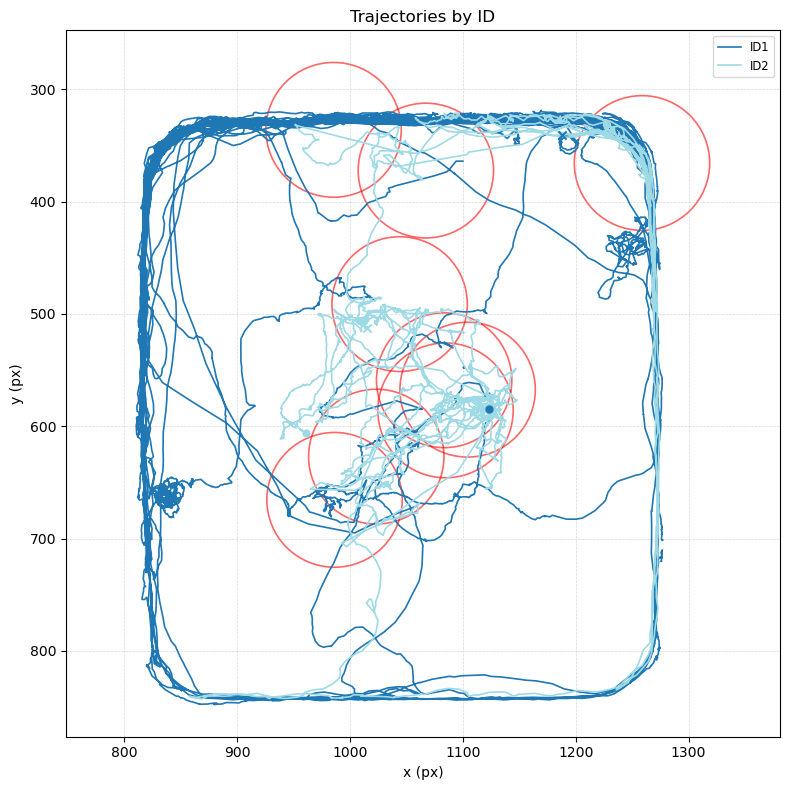

'/Users/beetlecrew/Downloads/trajectories_Trajectories.pdf'

In [ ]:
# -------------------------------------------------------------
# 6. SUMMARIZE DISTANCE TRAVELLED + PLOT TRAJECTORIES
# -------------------------------------------------------------
path_summary = compute_path_length_summary(df, ids, valid_by_id)
display(path_summary)

fig, trajectory_pdf_path = plot_trajectories(
    df,
    ids,
    valid_by_id,
    OUTPUT_PREFIX,
    proximity_segments_by_pair,
    THRESHOLD_PX,
)
display(fig)
plt.close(fig)

trajectory_pdf_path


## 7. Write the InqScribe file, QA CSV, and extra summaries
Save everything next to your trajectories: InqScribe text, frame-by-frame QA, path lengths, and the trajectory PDF.


In [ ]:
# -------------------------------------------------------------
# 7. WRITE FILES
# -------------------------------------------------------------
# 7a. InqScribe file
inqscribe_path = f"{OUTPUT_PREFIX}_InqScribe_{int(THRESHOLD_PX)}px_{FPS:.3f}fps.txt"
with open(inqscribe_path, "w", encoding="utf-8-sig", newline="\n") as f:
    writer = csv.writer(f, delimiter="	", lineterminator="\n")
    writer.writerow(["Start Time", "End Time", "Title", "Comment"])
    for start_s, end_s, title, comment in events:
        writer.writerow([
            fmt_hhmmss_comma_ms(start_s),
            fmt_hhmmss_comma_ms(end_s),
            title,
            comment,
        ])

# 7b. QA CSV (frame-by-frame info for every pair)
qa_data = {
    "frame": frames,
    "time_s": time_seconds,
}
for beetle_id in ids:
    qa_data[f"id{beetle_id}_valid"] = valid_by_id[beetle_id].astype(int).to_numpy()
for (beetle_i, beetle_j), distances in distance_by_pair.items():
    qa_data[f"distance_px_{beetle_i}_{beetle_j}"] = distances
    qa_data[f"contact_le_{int(THRESHOLD_PX)}px_{beetle_i}_{beetle_j}"] = contact_mask_by_pair[(beetle_i, beetle_j)].astype(int)

qa_df = pd.DataFrame(qa_data)
qa_path = f"{OUTPUT_PREFIX}_QA_by_frame.csv"
qa_df.to_csv(qa_path, index=False)

# 7c. Path length summary CSV (from step 6)
path_summary_path = f"{OUTPUT_PREFIX}_PerIDPathLength.csv"
path_summary.to_csv(path_summary_path, index=False)

print("InqScribe file:", inqscribe_path)
print("QA CSV:", qa_path)
print("Path summary CSV:", path_summary_path)
print("Trajectory PDF:", trajectory_pdf_path)

inqscribe_path, qa_path, path_summary_path, trajectory_pdf_path

InqScribe file: /Users/beetlecrew/Downloads/trajectories_InqScribe_60px_30.000fps.txt
QA CSV: /Users/beetlecrew/Downloads/trajectories_QA_by_frame.csv
Path summary CSV: /Users/beetlecrew/Downloads/trajectories_PerIDPathLength.csv
Trajectory PDF: /Users/beetlecrew/Downloads/trajectories_Trajectories.pdf


('/Users/beetlecrew/Downloads/trajectories_InqScribe_60px_30.000fps.txt',
 '/Users/beetlecrew/Downloads/trajectories_QA_by_frame.csv',
 '/Users/beetlecrew/Downloads/trajectories_PerIDPathLength.csv',
 '/Users/beetlecrew/Downloads/trajectories_Trajectories.pdf')